<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-TPC-H-Benchmarking-Throughput" data-toc-modified-id="Evaluation-of-TPC-H-Benchmarking-Throughput-1">Evaluation of TPC-H Benchmarking Throughput</a></span><ul class="toc-item"><li><span><a href="#Import-some-libraries" data-toc-modified-id="Import-some-libraries-1.1">Import some libraries</a></span></li></ul></li><li><span><a href="#Load-Results" data-toc-modified-id="Load-Results-2">Load Results</a></span><ul class="toc-item"><li><span><a href="#Load-Results-and-Generate-Common-DataFrame" data-toc-modified-id="Load-Results-and-Generate-Common-DataFrame-2.1">Load Results and Generate Common DataFrame</a></span></li><li><span><a href="#Results-in-Format-&quot;time&quot;" data-toc-modified-id="Results-in-Format-&quot;time&quot;-2.2">Results in Format "time"</a></span></li><li><span><a href="#Results-in-Format-&quot;Throughput&quot;" data-toc-modified-id="Results-in-Format-&quot;Throughput&quot;-2.3">Results in Format "Throughput"</a></span></li></ul></li><li><span><a href="#Loading-Phase" data-toc-modified-id="Loading-Phase-3">Loading Phase</a></span><ul class="toc-item"><li><span><a href="#Plot-Throughput" data-toc-modified-id="Plot-Throughput-3.1">Plot Throughput</a></span></li><li><span><a href="#Plot-Time" data-toc-modified-id="Plot-Time-3.2">Plot Time</a></span></li><li><span><a href="#Plot-Indexing" data-toc-modified-id="Plot-Indexing-3.3">Plot Indexing</a></span></li><li><span><a href="#Plot-Constraints" data-toc-modified-id="Plot-Constraints-3.4">Plot Constraints</a></span></li><li><span><a href="#Plot-Statistics" data-toc-modified-id="Plot-Statistics-3.5">Plot Statistics</a></span></li></ul></li><li><span><a href="#Benchmarking-Phase" data-toc-modified-id="Benchmarking-Phase-4">Benchmarking Phase</a></span><ul class="toc-item"><li><span><a href="#Plot-Throughput" data-toc-modified-id="Plot-Throughput-4.1">Plot Throughput</a></span></li><li><span><a href="#Plot-Hardware-Metrics" data-toc-modified-id="Plot-Hardware-Metrics-4.2">Plot Hardware Metrics</a></span></li></ul></li></ul></div>

# Evaluation of TPC-H Benchmarking Throughput

<img src="https://raw.githubusercontent.com/Beuth-Erdelt/Benchmark-Experiment-Host-Manager/master/docs/workflow-sketch-simple.png"/>

## Import some libraries

In [1]:
from dbmsbenchmarker import *
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

# Some plotly figures
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Some nice output
from IPython.display import display, Markdown

import logging
logging.basicConfig(level=logging.INFO)

import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [2]:
# path of folder containing experiment results
resultfolder = "./"

# create evaluation object for result folder
evaluate = inspector.inspector(resultfolder)

# list of experiments to be combined
codes = [1686234009,1686236492,1686228050,1686238015]

# Load Results

In [3]:
import ast
import json
import statistics
import pandas as pd

def generate_df(code):
    global SF, dbms, imported, portion_of_data
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    # loading
    evaluate.load_experiment(code)
    df = evaluate.get_loading_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory = df[0]
    df = evaluate.get_loading_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu = df[0]
    # benchmarking
    df = evaluate.get_streaming_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_stream = df[0]
    df = evaluate.get_streaming_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_stream = df[0]
    # data generator
    df = evaluate.get_datagenerator_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_datagenerator = df[0]
    #print(hw_memory_datagenerator)
    df = evaluate.get_datagenerator_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_datagenerator = df[0]
    # loader
    df = evaluate.get_loader_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_loader = df[0]
    df = evaluate.get_loader_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_loader = df[0]
    # benchmarker
    df = evaluate.get_benchmarker_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_benchmarker = df[0]
    df = evaluate.get_benchmarker_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_benchmarker = df[0]
    # benchmark
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Mean', total_aggregate='Mean')
    df_mean = (df/1000.0).sort_index()
    #print(df_mean)
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df_geo = (df/1000.0).sort_index()
    #print(df_geo)
    #df_metric[0]['PostgreSQL-BHT-1-1-1']
    #df_metric.plot()
    #pretty_connections = json.dumps(connections, indent=2)
    df_merged_time = pd.DataFrame()
    df_merged_tpx = pd.DataFrame()
    for c in connections_sorted:
        #print(c)
        connection_name = c['name']
        orig_name = c['orig_name']
        #print(connection_name, orig_name)
        properties = evaluate.get_experiment_connection_properties(connection_name)
        dbms = properties['docker']
        #print(properties)
        # load
        if orig_name in hw_cpu:
            hw_cpu_c = hw_cpu[orig_name]
        else:
            hw_cpu_c = 0
        if orig_name in hw_memory:
            hw_memory_c = hw_memory[orig_name]
        else:
            hw_memory_c = 0
        # stream
        if orig_name in hw_cpu_stream:
            hw_cpu_stream_c = hw_cpu_stream[orig_name]
        else:
            hw_cpu_stream_c = 0
        if orig_name in hw_memory_stream:
            hw_memory_stream_c = hw_memory_stream[orig_name]
        else:
            hw_memory_stream_c = 0
        # loader
        if orig_name in hw_cpu_loader:
            hw_cpu_loader_c = hw_cpu_loader[orig_name]
        else:
            hw_cpu_loader_c = 0
        if orig_name in hw_memory_loader:
            hw_memory_loader_c = hw_memory_loader[orig_name]
        else:
            hw_memory_loader_c = 0
        # data generator
        if orig_name in hw_cpu_datagenerator:
            hw_cpu_datagenerator_c = hw_cpu_datagenerator[orig_name]
        else:
            hw_cpu_datagenerator_c = 0
        if orig_name in hw_memory_datagenerator:
            hw_memory_datagenerator_c = hw_memory_datagenerator[orig_name]
        else:
            hw_memory_datagenerator_c = 0
        # benchmarker
        if orig_name in hw_cpu_benchmarker:
            hw_cpu_benchmarker_c = hw_cpu_benchmarker[orig_name]
        else:
            hw_cpu_benchmarker_c = 0
        if orig_name in hw_memory_benchmarker:
            hw_memory_benchmarker_c = hw_memory_benchmarker[orig_name]
        else:
            hw_memory_benchmarker_c = 0
        results = dict()
        eva = evaluate.get_experiment_connection_properties(c['name'])
        SF = int(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        if 'TPCH_TABLE' in c['parameter']['connection_parameter']['loading_parameters']:
            TPCH_TABLE = c['parameter']['connection_parameter']['loading_parameters']['TPCH_TABLE']
        else:
            TPCH_TABLE = ''
        imported = TPCH_TABLE
        if len(c['hostsystem']['loading_timespans']['sensor']) == 0:
            continue
        timespan_load = max([end for (start,end) in c['hostsystem']['loading_timespans']['sensor']]) - min([start for (start,end) in c['hostsystem']['loading_timespans']['sensor']])
        timespan_benchmark = eva['times']['total'][c['name']]['time_end']-eva['times']['total'][c['name']]['time_start']
        results[connection_name] = {
            'load':eva['times']['load_ms']/1000.,
            'ingest':eva['times']['ingest_ms']/1000.,
            'generate':eva['times']['generate_ms']/1000.,
            'schema':eva['times']['schema_ms']/1000.,
            #'index':eva['times']['index_ms']/1000.,
            'loaded':eva['times']['script_times']['loaded'],
            'initschema':eva['times']['script_times']['initschema'],
            'span_load':timespan_load,
            'span_benchmark':timespan_benchmark,
            #'mean_generate': statistics.mean([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            #'max_generate': max([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            #'min_generate': min([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            'mean_load': statistics.mean([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'max_load': max([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'min_load': min([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'span_generate': c['timeGenerate'],
            #'pods': int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL']),
            #'indexed':eva['times']['script_times']['indexed'],
            'initindexes':eva['times']['script_times']['initindexes'],
            'initconstraints':eva['times']['script_times']['initconstraints'],
            'initstatistics':eva['times']['script_times']['initstatistics'],
            'benchmark_mean':df_mean.loc[connection_name]['total_timer_run'],
            'benchmark_geo':df_geo.loc[connection_name]['total_timer_run'],
        }
        # DataFrame of time
        df = pd.DataFrame(results).T
        df_time = df.copy()
        df_tpx = df.copy()
        # Compute DataFrame of throughput (Tpx)
        df_tpx = 3600*int(SF)/df_tpx * portion_of_data
        # Set Values that are same for time and tpx
        df_time['SF'] = int(SF)
        df_tpx['SF'] = int(SF)
        df_time['dbms'] = dbms
        df_tpx['dbms'] = dbms
        df_time['TPCH_TABLE'] = TPCH_TABLE
        df_tpx['TPCH_TABLE'] = TPCH_TABLE
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        df_tpx['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        #df_tpx['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_tpx['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_tpx['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_tpx['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_tpx['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_time['mem_max_load'] = hw_memory_c
        df_tpx['mem_max_load'] = hw_memory_c
        # load
        df_time['mem_max_load'] = hw_memory_c
        df_tpx['mem_max_load'] = hw_memory_c
        df_time['cpu_total_load'] = hw_cpu_c
        df_tpx['cpu_total_load'] = hw_cpu_c
        # stream
        df_time['mem_max_stream'] = hw_memory_stream_c
        df_tpx['mem_max_stream'] = hw_memory_stream_c
        df_time['cpu_total_stream'] = hw_cpu_stream_c
        df_tpx['cpu_total_stream'] = hw_cpu_stream_c
        # loader
        df_time['mem_max_loader'] = hw_memory_loader_c
        df_tpx['mem_max_loader'] = hw_memory_loader_c
        df_time['cpu_total_loader'] = hw_cpu_loader_c
        df_tpx['cpu_total_loader'] = hw_cpu_loader_c
        # data generator
        df_time['mem_max_datagenerator'] = hw_memory_datagenerator_c
        df_tpx['mem_max_datagenerator'] = hw_memory_datagenerator_c
        df_time['cpu_total_datagenerator'] = hw_cpu_datagenerator_c
        df_tpx['cpu_total_datagenerator'] = hw_cpu_datagenerator_c
        # benchmarker
        df_time['mem_max_benchmarker'] = hw_memory_benchmarker_c
        df_tpx['mem_max_benchmarker'] = hw_memory_benchmarker_c
        df_time['cpu_total_benchmarker'] = hw_cpu_benchmarker_c
        df_tpx['cpu_total_benchmarker'] = hw_cpu_benchmarker_c
        df_merged_time = pd.concat([df_merged_time, df_time])
        df_merged_tpx = pd.concat([df_merged_tpx, df_tpx])
    return df_merged_time, df_merged_tpx

def merge_experiments(df_time, df_tpx, code):
    df_time_tmp, df_tpx_tmp = generate_df(code)
    df_time = pd.concat([df_time, df_time_tmp])
    df_tpx = pd.concat([df_tpx, df_tpx_tmp])
    return df_time, df_tpx

## Load Results and Generate Common DataFrame

In [4]:
df_time = pd.DataFrame()
df_tpx = pd.DataFrame()

portion_of_data = 1.0 # for lineitem table = 0.7, for all tables = 1.0

for code in codes:
    df_time, df_tpx = merge_experiments(df_time, df_tpx, code)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


## Results in Format "time"

In [5]:
df_time.T

,PostgreSQL-AWS-4-1-1,PostgreSQL-AWS-4-10-1,PostgreSQL-AWS-4-10-10,PostgreSQL-AWS-4-10-2,PostgreSQL-AWS-4-10-3,PostgreSQL-AWS-4-10-4,PostgreSQL-AWS-4-10-5,PostgreSQL-AWS-4-10-6,PostgreSQL-AWS-4-10-7,PostgreSQL-AWS-4-10-8,...,PostgreSQL-AWS-4-8-8,PostgreSQL-AWS-4-9-1,PostgreSQL-AWS-4-9-2,PostgreSQL-AWS-4-9-3,PostgreSQL-AWS-4-9-4,PostgreSQL-AWS-4-9-5,PostgreSQL-AWS-4-9-6,PostgreSQL-AWS-4-9-7,PostgreSQL-AWS-4-9-8,PostgreSQL-AWS-4-9-9
benchmark_geo,0.626844,0.632627,0.620555,0.6372,0.634936,0.64451,0.650121,0.641237,0.636856,0.636409,...,14.997548,17.628742,17.099679,16.880599,16.835358,16.865565,17.149394,16.856538,15.694917,14.790488
benchmark_mean,0.87009,0.900167,0.871424,0.911793,0.902629,0.905444,0.92747,0.911566,0.897627,0.901916,...,28.315948,30.449043,30.662218,30.583163,30.53988,30.480332,31.575404,31.704748,32.871015,32.638396
generate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ingest,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,672.0,672.0,672.0,672.0,672.0,672.0,672.0,672.0,672.0,672.0
initconstraints,29.036005,29.036005,29.036005,29.036005,29.036005,29.036005,29.036005,29.036005,29.036005,29.036005,...,1354.0928,1354.0928,1354.0928,1354.0928,1354.0928,1354.0928,1354.0928,1354.0928,1354.0928,1354.0928
initindexes,7.205218,7.205218,7.205218,7.205218,7.205218,7.205218,7.205218,7.205218,7.205218,7.205218,...,205.071821,205.071821,205.071821,205.071821,205.071821,205.071821,205.071821,205.071821,205.071821,205.071821
initschema,1.211485,1.211485,1.211485,1.211485,1.211485,1.211485,1.211485,1.211485,1.211485,1.211485,...,1.118685,1.118685,1.118685,1.118685,1.118685,1.118685,1.118685,1.118685,1.118685,1.118685
initstatistics,20.242573,20.242573,20.242573,20.242573,20.242573,20.242573,20.242573,20.242573,20.242573,20.242573,...,43.233445,43.233445,43.233445,43.233445,43.233445,43.233445,43.233445,43.233445,43.233445,43.233445
load,76.836504,76.836504,76.836504,76.836504,76.836504,76.836504,76.836504,76.836504,76.836504,76.836504,...,2277.665694,2277.665694,2277.665694,2277.665694,2277.665694,2277.665694,2277.665694,2277.665694,2277.665694,2277.665694
loaded,2.288853,2.288853,2.288853,2.288853,2.288853,2.288853,2.288853,2.288853,2.288853,2.288853,...,2.153249,2.153249,2.153249,2.153249,2.153249,2.153249,2.153249,2.153249,2.153249,2.153249


## Results in Format "Throughput"

In [6]:
df_tpx.T

,PostgreSQL-AWS-4-1-1,PostgreSQL-AWS-4-10-1,PostgreSQL-AWS-4-10-10,PostgreSQL-AWS-4-10-2,PostgreSQL-AWS-4-10-3,PostgreSQL-AWS-4-10-4,PostgreSQL-AWS-4-10-5,PostgreSQL-AWS-4-10-6,PostgreSQL-AWS-4-10-7,PostgreSQL-AWS-4-10-8,...,PostgreSQL-AWS-4-8-8,PostgreSQL-AWS-4-9-1,PostgreSQL-AWS-4-9-2,PostgreSQL-AWS-4-9-3,PostgreSQL-AWS-4-9-4,PostgreSQL-AWS-4-9-5,PostgreSQL-AWS-4-9-6,PostgreSQL-AWS-4-9-7,PostgreSQL-AWS-4-9-8,PostgreSQL-AWS-4-9-9
benchmark_geo,5743.059573,5690.559545,5801.257852,5649.719574,5669.866608,5585.640919,5537.427447,5614.148176,5652.773429,5656.741898,...,7201.176956,6126.359039,6315.907996,6397.877399,6415.070037,6403.580297,6297.598488,6407.009574,6881.208745,7301.99031
benchmark_mean,4137.501667,3999.257534,4131.167805,3948.264563,3988.347981,3975.949458,3881.525131,3949.24657,4010.576062,3991.500646,...,3814.105044,3546.909561,3522.250063,3531.354808,3536.359665,3543.268525,3420.383738,3406.429901,3285.569354,3308.9861
generate,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
ingest,211.764706,211.764706,211.764706,211.764706,211.764706,211.764706,211.764706,211.764706,211.764706,211.764706,...,160.714286,160.714286,160.714286,160.714286,160.714286,160.714286,160.714286,160.714286,160.714286,160.714286
initconstraints,123.984,123.984,123.984,123.984,123.984,123.984,123.984,123.984,123.984,123.984,...,79.758197,79.758197,79.758197,79.758197,79.758197,79.758197,79.758197,79.758197,79.758197,79.758197
initindexes,499.637925,499.637925,499.637925,499.637925,499.637925,499.637925,499.637925,499.637925,499.637925,499.637925,...,526.64476,526.64476,526.64476,526.64476,526.64476,526.64476,526.64476,526.64476,526.64476,526.64476
initschema,2971.56034,2971.56034,2971.56034,2971.56034,2971.56034,2971.56034,2971.56034,2971.56034,2971.56034,2971.56034,...,96541.908009,96541.908009,96541.908009,96541.908009,96541.908009,96541.908009,96541.908009,96541.908009,96541.908009,96541.908009
initstatistics,177.843008,177.843008,177.843008,177.843008,177.843008,177.843008,177.843008,177.843008,177.843008,177.843008,...,2498.066013,2498.066013,2498.066013,2498.066013,2498.066013,2498.066013,2498.066013,2498.066013,2498.066013,2498.066013
load,46.85273,46.85273,46.85273,46.85273,46.85273,46.85273,46.85273,46.85273,46.85273,46.85273,...,47.416967,47.416967,47.416967,47.416967,47.416967,47.416967,47.416967,47.416967,47.416967,47.416967
loaded,1572.840147,1572.840147,1572.840147,1572.840147,1572.840147,1572.840147,1572.840147,1572.840147,1572.840147,1572.840147,...,50156.751785,50156.751785,50156.751785,50156.751785,50156.751785,50156.751785,50156.751785,50156.751785,50156.751785,50156.751785


# Loading Phase

## Plot Throughput

SF,1,3,10,30
pods,,,,
4.0,211.764706,192.857143,175.609756,160.714286


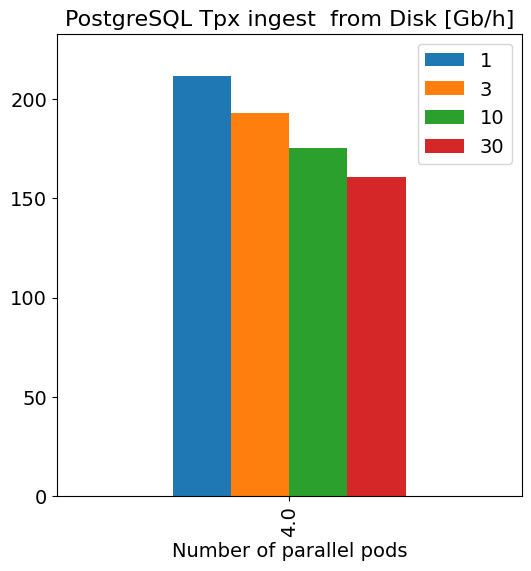

In [7]:
%matplotlib inline

df_tpx = df_tpx.astype({'pods':'int', 'span_load': 'float'})
df_tpx2 = df_tpx.drop(['dbms','TPCH_TABLE'], axis=1)

df_tpx_pivot = df_tpx2.groupby(['SF', 'num_experiment']).mean()
df_tpx_pivot.reset_index(inplace=True)
df_tpx_pivot = df_tpx_pivot.pivot(index='pods', columns='SF', values='span_load')

df_tpx_pivot.plot.bar(column='span_load', style='.-', figsize=(6,6), fontsize=14)#, logx=True)
plt.legend(fontsize=14)
plt.xlabel('Number of parallel pods', fontsize=14)
plt.ylim(0, df_tpx_pivot.max().max()*1.1)
plt.title("{dbms} Tpx ingest {imported} from Disk [Gb/h]".format(dbms=dbms, imported=imported), fontsize=16)

df_tpx_pivot

## Plot Time

SF,1,3,10,30
pods,,,,
4.0,17.0,56.0,205.0,672.0


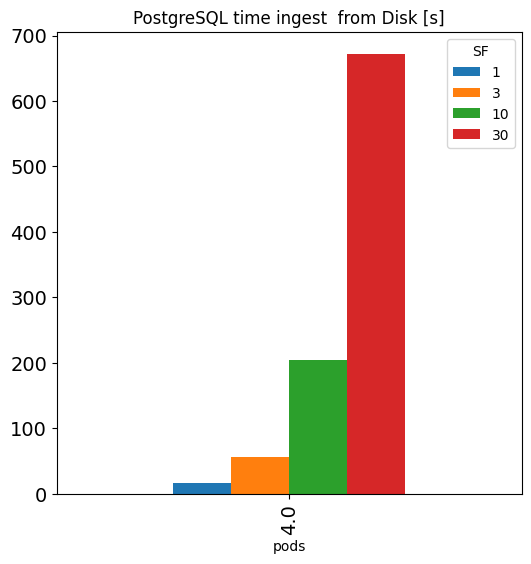

In [8]:
%matplotlib inline

df_time = df_time.astype({'pods':'int', 'span_load': 'float'})
df_time2 = df_time.drop(['dbms','TPCH_TABLE'], axis=1)

#df_time_pivot = df_time.pivot(index='pods', columns='SF', values='span_load')
df_time_pivot = df_time2.groupby(['SF', 'num_experiment']).mean()
df_time_pivot.reset_index(inplace=True)
df_time_pivot = df_time_pivot.pivot(index='pods', columns='SF', values='span_load')

df_time_pivot.plot.bar(style='.-', title='{dbms} time ingest {imported} from Disk [s]'.format(dbms=dbms, imported=imported), figsize=(6,6), fontsize=14)#, logx=True)

df_time_pivot

## Plot Indexing

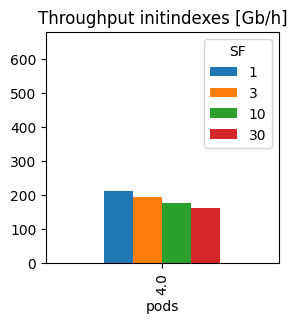

In [9]:
column = 'initindexes'
if df_time[column].max() > 0:
    df_tpx_pivot.plot.bar(column=column, figsize=(3,3), grid=False)
    plt.title('Throughput '+column+' [Gb/h]')
    plt.suptitle('')
    plt.ylim(0, df_tpx[column].max()*1.1)

## Plot Constraints

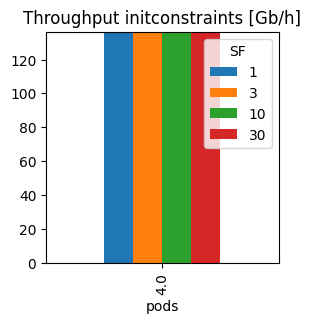

In [10]:
column = 'initconstraints'
if df_time[column].max() > 0:
    df_tpx_pivot.plot.bar(column=column, figsize=(3,3), grid=False)
    plt.title('Throughput '+column+' [Gb/h]')
    plt.suptitle('')
    plt.ylim(0, df_tpx[column].max()*1.1)

## Plot Statistics

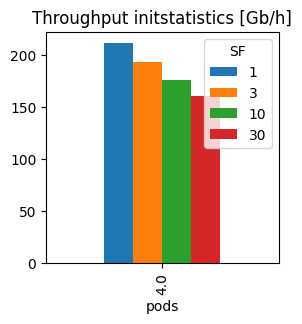

In [11]:
column = 'initstatistics'
if df_time[column].max() > 0:
    df_tpx_pivot.plot.bar(column=column, figsize=(3,3), grid=False)
    plt.title('Throughput '+column+' [Gb/h]')
    plt.suptitle('')
    #plt.ylim(0, df_tpx_pivot[column].max()*1.1)

# Benchmarking Phase

In [12]:
benchmark_start = df_time.groupby(['SF', 'num_experiment', 'num_client']).min('benchmark_start')

benchmark_start

benchmark_geo  benchmark_mean  generate  ingest  \
SF num_experiment num_client                                                    
1  1              1                0.626844        0.870090       0.0    17.0   
                  2                0.624912        0.877594       0.0    17.0   
                  3                0.629116        0.888116       0.0    17.0   
                  4                0.621419        0.871111       0.0    17.0   
                  5                0.625231        0.882196       0.0    17.0   
                  6                0.620819        0.873909       0.0    17.0   
                  7                0.625912        0.886332       0.0    17.0   
                  8                0.616898        0.867791       0.0    17.0   
                  9                0.616639        0.869442       0.0    17.0   
                  10               0.620555        0.871424       0.0    17.0   
3  1              1                1.637411        2.337024       0.0    56.0   
                  2                1.615564        2.381898       0.0    56.0   
                  3                1.627704        2.399394       0.0    56.0   
                  4                1.639990        2.407944       0.0    56.0   
                  5                1.653012        2.422681       0.0    56.0   
                  6                1.657783        2.457802       0.0    56.0   
                  7                1.684695        2.477245       0.0    56.0   
                  8                1.713946        2.509459       0.0    56.0   
                  9                1.740239        2.512901       0.0    56.0   
                  10               1.779724        2.656800       0.0    56.0   
10 1              1                4.249538        6.697040       0.0   205.0   
                  2                4.241509        6.733446       0.0   205.0   
                  3                4.319135        6.866624       0.0   205.0   
                  4                4.357608        6.910564       0.0   205.0   
                  5                4.444132        7.157446       0.0   205.0   
                  6                4.556069        7.458999       0.0   205.0   
                  7                4.759533        8.017166       0.0   205.0   
                  8                4.936151        8.304516       0.0   205.0   
                  9                5.231177        8.596706       0.0   205.0   
                  10               5.392703        8.895940       0.0   205.0   
30 1              1               11.848516       20.773472       0.0   672.0   
                  2               11.560896       20.736863       0.0   672.0   
                  3               11.551032       20.878200       0.0   672.0   
                  4               12.034596       21.469454       0.0   672.0   
                  5               12.992434       22.567123       0.0   672.0   
                  6               13.718017       25.209100       0.0   672.0   
                  7               14.459409       26.819507       0.0   672.0   
                  8               14.997548       28.170066       0.0   672.0   
                  9               14.790488       30.449043       0.0   672.0   
                  10              16.690499       30.843552       0.0   672.0   

                              initconstraints  initindexes  initschema  \
SF num_experiment num_client                                             
1  1              1                 29.036005     7.205218    1.211485   
                  2                 29.036005     7.205218    1.211485   
                  3                 29.036005     7.205218    1.211485   
                  4                 29.036005     7.205218    1.211485   
                  5                 29.036005     7.205218    1.211485   
                  6                 29.036005     7.205218    1.211485   
                  7                

In [13]:
benchmark_end = df_time.groupby(['SF', 'num_experiment', 'num_client']).max('benchmark_end')

benchmark_end

benchmark_geo  benchmark_mean  generate  ingest  \
SF num_experiment num_client                                                    
1  1              1                0.626844        0.870090       0.0    17.0   
                  2                0.627641        0.879075       0.0    17.0   
                  3                0.632130        0.899522       0.0    17.0   
                  4                0.630736        0.888230       0.0    17.0   
                  5                0.636013        0.924576       0.0    17.0   
                  6                0.640728        0.908141       0.0    17.0   
                  7                0.640812        0.916236       0.0    17.0   
                  8                0.632665        0.904015       0.0    17.0   
                  9                0.639336        0.914431       0.0    17.0   
                  10               0.650121        0.927470       0.0    17.0   
3  1              1                1.637411        2.337024       0.0    56.0   
                  2                1.629153        2.392267       0.0    56.0   
                  3                1.659287        2.451833       0.0    56.0   
                  4                1.660253        2.438937       0.0    56.0   
                  5                1.679546        2.461815       0.0    56.0   
                  6                1.701831        2.497585       0.0    56.0   
                  7                1.783129        2.628219       0.0    56.0   
                  8                1.827464        2.639318       0.0    56.0   
                  9                1.885180        2.698596       0.0    56.0   
                  10               2.000874        2.866765       0.0    56.0   
10 1              1                4.249538        6.697040       0.0   205.0   
                  2                4.256660        6.792321       0.0   205.0   
                  3                4.344926        7.031578       0.0   205.0   
                  4                4.403455        7.250765       0.0   205.0   
                  5                4.604848        7.543895       0.0   205.0   
                  6                4.858891        7.775989       0.0   205.0   
                  7                5.170702        8.477382       0.0   205.0   
                  8                5.374004        8.769735       0.0   205.0   
                  9                5.676579        9.179535       0.0   205.0   
                  10               6.060483        9.544057       0.0   205.0   
30 1              1               11.848516       20.773472       0.0   672.0   
                  2               11.590215       21.159031       0.0   672.0   
                  3               11.807706       21.721130       0.0   672.0   
                  4               12.315965       22.365024       0.0   672.0   
                  5               13.244481       24.931526       0.0   672.0   
                  6               14.096852       26.204070       0.0   672.0   
                  7               15.398105       28.600618       0.0   672.0   
                  8               16.289964       30.197897       0.0   672.0   
                  9               17.628742       32.871015       0.0   672.0   
                  10              19.279709       41.397282       0.0   672.0   

                              initconstraints  initindexes  initschema  \
SF num_experiment num_client                                             
1  1              1                 29.036005     7.205218    1.211485   
                  2                 29.036005     7.205218    1.211485   
                  3                 29.036005     7.205218    1.211485   
                  4                 29.036005     7.205218    1.211485   
                  5                 29.036005     7.205218    1.211485   
                  6                 29.036005     7.205218    1.211485   
                  7                

In [14]:
df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])

df_benchmark.columns = ['span_benchmark']

df_benchmark

span_benchmark
SF num_experiment num_client                
1  1              1                       22
                  2                       25
                  3                       32
                  4                       45
                  5                       48
                  6                       55
                  7                       59
                  8                       69
                  9                       81
                  10                      82
3  1              1                       56
                  2                       62
                  3                       75
                  4                       75
                  5                       82
                  6                       87
                  7                      102
                  8                      114
                  9                      117
                  10                     123
10 1              1                      153
                  2                      160
                  3                      173
                  4                      185
                  5                      202
                  6                      213
                  7                      223
                  8                      247
                  9                      254
                  10                     269
30 1              1                     4044
                  2                     4056
                  3                     4066
                  4                     4100
                  5                     4156
                  6                     4199
                  7                     4235
                  8                     4283
                  9                     4350
                  10                    4550

In [15]:
benchmark_count = df_time.groupby(['SF', 'num_experiment', 'num_client']).count()

benchmark_count

benchmark_geo  benchmark_mean  generate  ingest  \
SF num_experiment num_client                                                    
1  1              1                       1               1         1       1   
                  2                       2               2         2       2   
                  3                       3               3         3       3   
                  4                       4               4         4       4   
                  5                       5               5         5       5   
                  6                       6               6         6       6   
                  7                       7               7         7       7   
                  8                       8               8         8       8   
                  9                       9               9         9       9   
                  10                     10              10        10      10   
3  1              1                       1               1         1       1   
                  2                       2               2         2       2   
                  3                       3               3         3       3   
                  4                       4               4         4       4   
                  5                       5               5         5       5   
                  6                       6               6         6       6   
                  7                       7               7         7       7   
                  8                       8               8         8       8   
                  9                       9               9         9       9   
                  10                     10              10        10      10   
10 1              1                       1               1         1       1   
                  2                       2               2         2       2   
                  3                       3               3         3       3   
                  4                       4               4         4       4   
                  5                       5               5         5       5   
                  6                       6               6         6       6   
                  7                       7               7         7       7   
                  8                       8               8         8       8   
                  9                       9               9         9       9   
                  10                     10              10        10      10   
30 1              1                       1               1         1       1   
                  2                       2               2         2       2   
                  3                       3               3         3       3   
                  4                       4               4         4       4   
                  5                       5               5         5       5   
                  6                       6               6         6       6   
                  7                       7               7         7       7   
                  8                       8               8         8       8   
                  9                       9               9         9       9   
                  10                     10              10        10      10   

                              initconstraints  initindexes  initschema  \
SF num_experiment num_client                                             
1  1              1                         1            1           1   
                  2                         2            2           2   
                  3                         3            3           3   
                  4                         4            4           4   
                  5                         5            5           5   
                  6                         6            6           6   
                  7                

In [16]:
df_benchmark['count'] = benchmark_count['benchmark_geo']

df_benchmark

span_benchmark  count
SF num_experiment num_client                       
1  1              1                       22      1
                  2                       25      2
                  3                       32      3
                  4                       45      4
                  5                       48      5
                  6                       55      6
                  7                       59      7
                  8                       69      8
                  9                       81      9
                  10                      82     10
3  1              1                       56      1
                  2                       62      2
                  3                       75      3
                  4                       75      4
                  5                       82      5
                  6                       87      6
                  7                      102      7
                  8                      114      8
                  9                      117      9
                  10                     123     10
10 1              1                      153      1
                  2                      160      2
                  3                      173      3
                  4                      185      4
                  5                      202      5
                  6                      213      6
                  7                      223      7
                  8                      247      8
                  9                      254      9
                  10                     269     10
30 1              1                     4044      1
                  2                     4056      2
                  3                     4066      3
                  4                     4100      4
                  5                     4156      5
                  6                     4199      6
                  7                     4235      7
                  8                     4283      8
                  9                     4350      9
                  10                    4550     10

In [17]:
df_benchmark['SF'] = df_benchmark.index.map(lambda x: x[0])
df_benchmark['tpx'] = 22*3600*df_benchmark['count']/df_benchmark['span_benchmark']*df_benchmark['SF']

df_benchmark

span_benchmark  count  SF           tpx
SF num_experiment num_client                                         
1  1              1                       22      1   1   3600.000000
                  2                       25      2   1   6336.000000
                  3                       32      3   1   7425.000000
                  4                       45      4   1   7040.000000
                  5                       48      5   1   8250.000000
                  6                       55      6   1   8640.000000
                  7                       59      7   1   9396.610169
                  8                       69      8   1   9182.608696
                  9                       81      9   1   8800.000000
                  10                      82     10   1   9658.536585
3  1              1                       56      1   3   4242.857143
                  2                       62      2   3   7664.516129
                  3                       75      3   3   9504.000000
                  4                       75      4   3  12672.000000
                  5                       82      5   3  14487.804878
                  6                       87      6   3  16386.206897
                  7                      102      7   3  16305.882353
                  8                      114      8   3  16673.684211
                  9                      117      9   3  18276.923077
                  10                     123     10   3  19317.073171
10 1              1                      153      1  10   5176.470588
                  2                      160      2  10   9900.000000
                  3                      173      3  10  13734.104046
                  4                      185      4  10  17124.324324
                  5                      202      5  10  19603.960396
                  6                      213      6  10  22309.859155
                  7                      223      7  10  24860.986547
                  8                      247      8  10  25651.821862
                  9                      254      9  10  28062.992126
                  10                     269     10  10  29442.379182
30 1              1                     4044      1  30    587.537092
                  2                     4056      2  30   1171.597633
                  3                     4066      3  30   1753.074274
                  4                     4100      4  30   2318.048780
                  5                     4156      5  30   2858.517806
                  6                     4199      6  30   3395.094070
                  7                     4235      7  30   3927.272727
                  8                     4283      8  30   4438.010740
                  9                     4350      9  30   4915.862069
                  10                    4550     10  30   5221.978022

## Plot Throughput

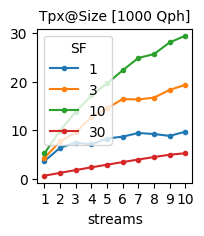

In [18]:
%matplotlib inline

df_benchmark_plot = df_benchmark.unstack(level=0).droplevel(0)
df_benchmark_plot['tpx'] = df_benchmark_plot['tpx']/1000
ax = df_benchmark_plot.plot(y='tpx', figsize=(2,2), grid=False, style=".-")
plt.title('Tpx@Size [1000 Qph]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
#plt.title("Tpx generate to disk [Gb/h]".format(dbms=dbms, imported=imported), fontsize=10)
#df_benchmark_plot.droplevel(0)

In [19]:
#df_time_multiindex = df_time.set_index(['SF', 'num_experiment', 'num_client'])
#df_time_multiindex

## Plot Hardware Metrics

In [20]:
df_time_hw = df_time.groupby(['SF', 'num_experiment', 'num_client']).max()

df_time_hw

benchmark_geo  benchmark_mean  generate  ingest  \
SF num_experiment num_client                                                    
1  1              1                0.626844        0.870090       0.0    17.0   
                  2                0.627641        0.879075       0.0    17.0   
                  3                0.632130        0.899522       0.0    17.0   
                  4                0.630736        0.888230       0.0    17.0   
                  5                0.636013        0.924576       0.0    17.0   
                  6                0.640728        0.908141       0.0    17.0   
                  7                0.640812        0.916236       0.0    17.0   
                  8                0.632665        0.904015       0.0    17.0   
                  9                0.639336        0.914431       0.0    17.0   
                  10               0.650121        0.927470       0.0    17.0   
3  1              1                1.637411        2.337024       0.0    56.0   
                  2                1.629153        2.392267       0.0    56.0   
                  3                1.659287        2.451833       0.0    56.0   
                  4                1.660253        2.438937       0.0    56.0   
                  5                1.679546        2.461815       0.0    56.0   
                  6                1.701831        2.497585       0.0    56.0   
                  7                1.783129        2.628219       0.0    56.0   
                  8                1.827464        2.639318       0.0    56.0   
                  9                1.885180        2.698596       0.0    56.0   
                  10               2.000874        2.866765       0.0    56.0   
10 1              1                4.249538        6.697040       0.0   205.0   
                  2                4.256660        6.792321       0.0   205.0   
                  3                4.344926        7.031578       0.0   205.0   
                  4                4.403455        7.250765       0.0   205.0   
                  5                4.604848        7.543895       0.0   205.0   
                  6                4.858891        7.775989       0.0   205.0   
                  7                5.170702        8.477382       0.0   205.0   
                  8                5.374004        8.769735       0.0   205.0   
                  9                5.676579        9.179535       0.0   205.0   
                  10               6.060483        9.544057       0.0   205.0   
30 1              1               11.848516       20.773472       0.0   672.0   
                  2               11.590215       21.159031       0.0   672.0   
                  3               11.807706       21.721130       0.0   672.0   
                  4               12.315965       22.365024       0.0   672.0   
                  5               13.244481       24.931526       0.0   672.0   
                  6               14.096852       26.204070       0.0   672.0   
                  7               15.398105       28.600618       0.0   672.0   
                  8               16.289964       30.197897       0.0   672.0   
                  9               17.628742       32.871015       0.0   672.0   
                  10              19.279709       41.397282       0.0   672.0   

                              initconstraints  initindexes  initschema  \
SF num_experiment num_client                                             
1  1              1                 29.036005     7.205218    1.211485   
                  2                 29.036005     7.205218    1.211485   
                  3                 29.036005     7.205218    1.211485   
                  4                 29.036005     7.205218    1.211485   
                  5                 29.036005     7.205218    1.211485   
                  6                 29.036005     7.205218    1.211485   
                  7                

In [21]:
df_time_benchmark = df_time.groupby(['SF', 'num_client']).max()
df_time_benchmark = pd.DataFrame(df_time_benchmark['span_benchmark']).T
df_time_benchmark.T

span_benchmark
SF num_client                
1  1                     22.0
   2                     23.0
   3                     24.0
   4                     24.0
   5                     24.0
   6                     24.0
   7                     25.0
   8                     24.0
   9                     25.0
   10                    25.0
3  1                     56.0
   2                     57.0
   3                     59.0
   4                     58.0
   5                     59.0
   6                     60.0
   7                     62.0
   8                     63.0
   9                     64.0
   10                    68.0
10 1                    153.0
   2                    154.0
   3                    160.0
   4                    165.0
   5                    172.0
   6                    176.0
   7                    192.0
   8                    198.0
   9                    207.0
   10                   215.0
30 1                   4044.0
   2                   4052.0
   3                   4064.0
   4                   4078.0
   5                   4132.0
   6                   4159.0
   7                   4209.0
   8                   4242.0
   9                   4299.0
   10                  4477.0

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(10, 1)
(10, 2)
(10, 3)
(10, 4)
(10, 5)
(10, 6)
(10, 7)
(10, 8)
(10, 9)
(10, 10)
(30, 1)
(30, 2)
(30, 3)
(30, 4)
(30, 5)
(30, 6)
(30, 7)
(30, 8)
(30, 9)
(30, 10)


(0.0, 4924.700000000001)

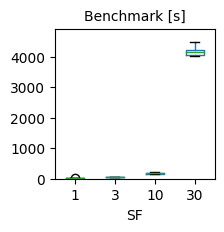

In [22]:
for index in df_time_benchmark.columns:
    print(index)
    #df_time_benchmark[(index)] = df_time_benchmark[index]/int(index[0])

df_time_benchmark.T.boxplot(column='span_benchmark', by='SF', figsize=(2,2), grid=False)
plt.title('Benchmark [s]', fontsize=10)
plt.suptitle('')
plt.ylim(0, df_time_benchmark.max().max()*1.1)

In [23]:
df_hw_pivot = df_time_hw[df_time_hw['cpu_total_stream']!=0].unstack(0)#.pivot(index='SF', columns='pods', values='cpu_total_stream')
df_hw_pivot

benchmark_geo                                 \
SF                                   1         3         10         30   
num_experiment num_client                                                
1              1               0.626844  1.637411  4.249538  11.848516   
               2               0.627641  1.629153  4.256660  11.590215   
               3               0.632130  1.659287  4.344926  11.807706   
               4               0.630736  1.660253  4.403455  12.315965   
               5               0.636013  1.679546  4.604848  13.244481   
               6               0.640728  1.701831  4.858891  14.096852   
               7               0.640812  1.783129  5.170702  15.398105   
               8               0.632665  1.827464  5.374004  16.289964   
               9               0.639336  1.885180  5.676579  17.628742   
               10              0.650121  2.000874  6.060483  19.279709   

                          benchmark_mean                                 \
SF                                    1         3         10         30   
num_experiment num_client                                                 
1              1                0.870090  2.337024  6.697040  20.773472   
               2                0.879075  2.392267  6.792321  21.159031   
               3                0.899522  2.451833  7.031578  21.721130   
               4                0.888230  2.438937  7.250765  22.365024   
               5                0.924576  2.461815  7.543895  24.931526   
               6                0.908141  2.497585  7.775989  26.204070   
               7                0.916236  2.628219  8.477382  28.600618   
               8                0.904015  2.639318  8.769735  30.197897   
               9                0.914431  2.698596  9.179535  32.871015   
               10               0.927470  2.866765  9.544057  41.397282   

                          generate       ... cpu_total_datagenerator     \
SF                              1    3   ...                      10 30   
num_experiment num_client                ...                              
1              1               0.0  0.0  ...                       0  0   
               2               0.0  0.0  ...                       0  0   
               3               0.0  0.0  ...                       0  0   
               4               0.0  0.0  ...                       0  0   
               5               0.0  0.0  ...                       0  0   
               6               0.0  0.0  ...                       0  0   
               7               0.0  0.0  ...                       0  0   
               8               0.0  0.0  ...                       0  0   
               9               0.0  0.0  ...                       0  0   
               10              0.0  0.0  ...                       0  0   

                          mem_max_benchmarker                                 \
SF                                         1            3    10           30   
num_experiment num_client                                                      
1              1                   208.652344   204.019531  0.0   238.613281   
               2                   611.730469   660.550781  0.0   653.542969   
               3                  1212.539062  1125.523438  0.0  1076.601562   
               4                  1863.578125  1840.070312  0.0  1478.449219   
               5                  2465.582031  2354.382812  0.0  1880.527344   
               6                  3037.617188  2808.136719  0.0  2268.343750   
               7                  2742.273438  2807.425781  0.0  2668.695312   
               8                  3084.117188  3293.394531  0.0  3035.449219   
               9                  3462.558594  3753.957031  0.0  3449.035156   
               10                 3894.109375  4150.222656  0.0  3723.453125   

                          cpu_total_benchmarker                       

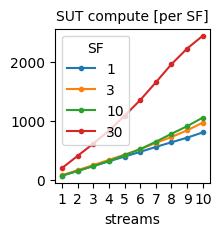

In [24]:
df_hw_pivot_2_plot  = df_hw_pivot.copy()#droplevel(0)
df_hw_pivot_2_plot
#df_hw_pivot_2_plot = df_hw_pivot_2.copy()
#df_hw_pivot_2_plot.droplevel(0)

for index in df_hw_pivot_2_plot['cpu_total_stream'].columns:
    #print(index)
    df_hw_pivot_2_plot[('cpu_total_stream',index)] = df_hw_pivot_2_plot['cpu_total_stream',index]/int(index)
    #print(df_hw_pivot_2_plot[('mem_max_stream',index)])


column = 'cpu_total_stream'
#df_hw_pivot_2_plot[column] = df_hw_pivot_2_plot[column]/1024.
#df_hw_pivot_2_plot = df_hw_pivot_2_plot['mem_max_stream'].index.droplevel(0)

#['mem_max_stream'].index.droplevel(0)
df_hw_pivot_2_plot = df_hw_pivot_2_plot.droplevel(0)

ax = df_hw_pivot_2_plot.plot(y=column, figsize=(2,2), grid=False, style=".-")
plt.title('SUT compute [per SF]'.format(dbms), fontsize=10)
plt.suptitle('')
#plt.title('Tpx@Size [1000 Qph]'.format(dbms), fontsize=10)
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(loc='upper left', title='SF')
#plt.ylim(0, df_means[column].max()*1.1)
#plt.xscale('log')
#plt.yscale('log')
#df_hw_pivot_2_plot.T


SF
1      8.036114
3     15.060738
10    22.657937
30    45.746578
dtype: float64

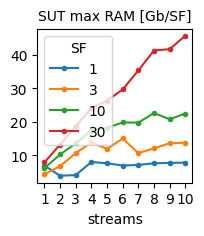

In [25]:
df_hw_pivot_2_plot  = df_hw_pivot.copy()#droplevel(0)
df_hw_pivot_2_plot
#df_hw_pivot_2_plot = df_hw_pivot_2.copy()
#df_hw_pivot_2_plot.droplevel(0)

for index in df_hw_pivot_2_plot['mem_max_stream'].columns:
    #print(index)
    df_hw_pivot_2_plot[('mem_max_stream',index)] = df_hw_pivot_2_plot['mem_max_stream',index]/int(index)
    #print(df_hw_pivot_2_plot[('mem_max_stream',index)])


column = 'mem_max_stream'
df_hw_pivot_2_plot[column] = df_hw_pivot_2_plot[column]/1024.
#df_hw_pivot_2_plot = df_hw_pivot_2_plot['mem_max_stream'].index.droplevel(0)

#['mem_max_stream'].index.droplevel(0)
df_hw_pivot_2_plot = df_hw_pivot_2_plot.droplevel(0)

ax = df_hw_pivot_2_plot.plot(y=column, figsize=(2,2), grid=False, style=".-")
plt.title('SUT max RAM [Gb/SF]'.format(dbms), fontsize=10)
plt.suptitle('')
#plt.title('Tpx@Size [1000 Qph]'.format(dbms), fontsize=10)
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(loc='upper left', title='SF')
#plt.ylim(0, df_means[column].max()*1.1)
#plt.xscale('log')
#plt.yscale('log')
#df_hw_pivot_2_plot.T
df_hw_pivot_2_plot[column].max()

In [26]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_streaming_metrics('total_cpu_util').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


,1,3,10,30
DBMS,,,,
1,2.925197,6.325603,7.290536,9.000576
2,7.373190,12.891595,14.601075,18.001615
3,9.825474,15.766660,20.998972,26.572984
4,9.916559,20.264882,27.996150,34.870364
5,13.846226,21.572946,35.011020,43.971000
6,13.035102,27.996733,40.438248,52.016224
7,15.284197,35.329831,46.495163,61.151688
8,18.066155,37.752712,53.969259,63.825899
9,16.729748,36.465671,56.431668,63.813964


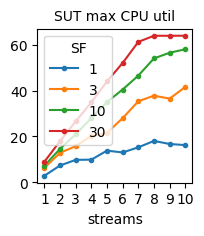

In [27]:
#fig, ax = plt.subplots()
ax = df_res.plot(figsize=(2,2), grid=False, style=".-", sharex=False)
plt.title('SUT max CPU util'.format(dbms), fontsize=10)
plt.suptitle('')
#ax.set_xlim(0,10)
ax.set_xticks(range(0,10), labels=["%s" % (int(item)) for item in df_res.index.tolist()], rotation=0)
ax.set_xlabel("streams")
#ax.get_figure().tight_layout()
#ax.xaxis.set_major_formatter(lambda x: float(x))
plt.legend(title='SF')
df_res

In [28]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_streaming_metrics('total_cpu_memory').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()/1000
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


,1,3,10,30
DBMS,,,,
1,7.128312,13.526434,63.269414,242.801102
2,4.038180,20.880320,105.405840,407.253375
3,4.229605,32.796660,139.284535,574.119574
4,8.228980,42.676199,178.609262,741.508152
5,7.845113,36.640883,186.933273,810.816473
6,7.161371,46.266586,203.244477,912.177176
7,7.329809,32.842848,202.702039,1086.867223
8,7.848301,37.285773,232.017277,1269.540586
9,7.971777,41.839031,213.051941,1282.160914


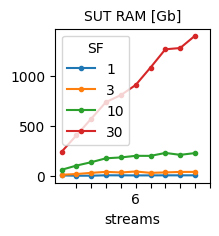

In [29]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('SUT RAM [Gb]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(title='SF')

df_res

In [30]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_streaming_metrics('total_cpu_memory_cached').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()/1000
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


,1,3,10,30
DBMS,,,,
1,8.785402,18.434281,79.560328,265.305297
2,5.695270,25.788168,121.696754,429.757570
3,5.886695,37.704508,155.575449,596.623770
4,9.886070,47.584047,194.900176,764.012348
5,9.502203,41.548730,203.224187,833.320668
6,8.818461,51.174434,219.535391,934.681371
7,8.986898,37.750695,218.992953,1109.371418
8,9.505391,42.193621,248.308191,1292.044781
9,9.628867,46.746879,229.342855,1304.665109


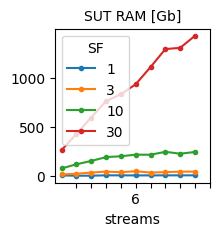

In [31]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('SUT RAM [Gb]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(title='SF')

df_res

In [32]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_streaming_metrics('total_cpu_util_s').T.max() - evaluate.get_streaming_metrics('total_cpu_util_s').T.min()
    df = pd.DataFrame(df)
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


,1,3,10,30
DBMS,,,,
1,80.012976,254.895022,786.669466,6184.898335
2,160.696836,513.052090,1587.744005,12370.134032
3,241.310310,774.232907,2417.887925,18572.865874
4,320.818782,1035.374460,3275.796691,25137.664373
5,402.095493,1301.766807,4246.551481,32702.073946
6,480.793733,1580.428484,5265.466408,40614.352894
7,564.956015,1896.309787,6528.646610,49626.594767
8,643.013221,2195.282286,7860.367871,58838.671861
9,721.034614,2532.981222,9147.668042,66750.954151


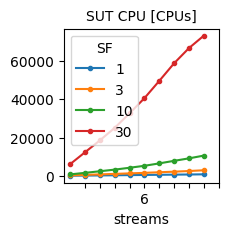

In [33]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('SUT CPU [CPUs]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(title='SF')
df_res

In [34]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_benchmarker_metrics('total_cpu_util').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


,1,3,10,30
DBMS,,,,
1,0.351637,0.452132,0.0,0.453909
2,0.274562,0.450193,0.0,0.906511
3,0.594639,0.875783,0.0,1.369124
4,0.692282,1.736767,0.0,0.482500
5,1.875298,1.333599,0.0,0.672106
6,1.182135,1.504793,0.0,2.428322
7,2.707533,2.880599,0.0,0.553262
8,1.685111,2.234767,0.0,2.064222
9,1.876792,3.372648,0.0,3.292659


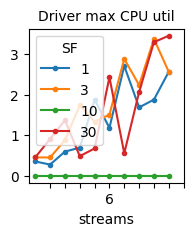

In [35]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('Driver max CPU util'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(title='SF')
df_res

In [36]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_benchmarker_metrics('total_cpu_util_max').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


,1,3,10,30


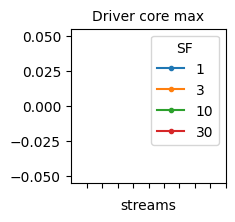

In [37]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('Driver core max'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(title='SF')
df_res

In [38]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_benchmarker_metrics('total_cpu_memory').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()/1000.
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


,1,3,10,30
DBMS,,,,
1,0.208652,0.204020,0.0,0.238613
2,0.611730,0.660551,0.0,0.653543
3,1.212539,1.125523,0.0,1.076602
4,1.863578,1.840070,0.0,1.478449
5,2.465582,2.354383,0.0,1.880527
6,3.037617,2.808137,0.0,2.268344
7,2.742273,2.807426,0.0,2.668695
8,3.084117,3.293395,0.0,3.035449
9,3.462559,3.753957,0.0,3.449035


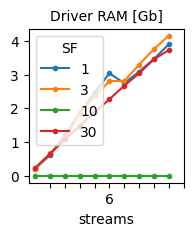

In [39]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('Driver RAM [Gb]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(title='SF')
df_res

In [40]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_benchmarker_metrics('total_cpu_memory_cached').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()/1000.
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
Results in folder .//1686236492
Read results
Load Evaluation
Results in folder .//1686228050
Read results
Load Evaluation
Results in folder .//1686238015
Read results
Load Evaluation


,1,3,10,30
DBMS,,,,
1,0.211746,0.208016,0.0,0.244414
2,0.619078,0.672410,0.0,0.664113
3,1.226977,1.140477,0.0,1.095809
4,1.886910,1.864305,0.0,1.503844
5,2.497164,2.385965,0.0,1.914688
6,3.078094,2.848871,0.0,2.304051
7,2.780430,2.859117,0.0,2.710203
8,3.129750,3.352691,0.0,3.082242
9,3.511543,3.821375,0.0,3.505238


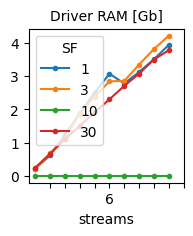

In [41]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('Driver RAM [Gb]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(1,11))
plt.legend(title='SF')
df_res

In [42]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_benchmarker_metrics('total_cpu_util_s').T.max() - evaluate.get_benchmarker_metrics('total_cpu_util_s').T.min()
    df = pd.DataFrame(df)
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-4-'):])
    df_res[SF] = df.copy()
    #df.T.max().plot.bar()

print(df_res)

Results in folder .//1686234009
Read results
Load Evaluation
found 55 connections
Results in folder .//1686236492
Read results
Load Evaluation
found 55 connections
Results in folder .//1686228050
Read results
Load Evaluation
found 55 connections
Results in folder .//1686238015
Read results
Load Evaluation
found 55 connections
              1          3   10          30
DBMS                                       
1      6.357339   7.368385  0.0   13.309727
2     12.480364  14.698020  0.0   15.027941
3     21.294983  16.856276  0.0   27.752162
4     28.945682  21.739376  0.0   42.074733
5     35.623551  25.390574  0.0   56.977909
6     41.721285  26.741739  0.0   62.487400
7     17.090795  49.581324  0.0   81.235520
8     48.048381  67.042332  0.0   98.604956
9     61.486374  75.274546  0.0  110.060736
10    61.253136  84.710041  0.0  123.735284


,1,3,10,30
DBMS,,,,
1,6.357339,7.368385,0.0,13.309727
2,12.480364,14.698020,0.0,15.027941
3,21.294983,16.856276,0.0,27.752162
4,28.945682,21.739376,0.0,42.074733
5,35.623551,25.390574,0.0,56.977909
6,41.721285,26.741739,0.0,62.487400
7,17.090795,49.581324,0.0,81.235520
8,48.048381,67.042332,0.0,98.604956
9,61.486374,75.274546,0.0,110.060736


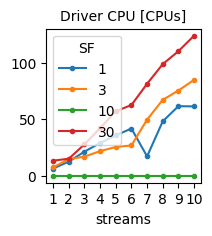

In [43]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('Driver CPU [CPUs]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
ax.set_xticks(range(0,10), labels=["%s" % (int(item)) for item in df_res.index.tolist()], rotation=0)
plt.legend(title='SF')
df_res